In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

# Vision - Multi-label Classification
### Planet: Understanding the Amazon from Space

# Get data

In [6]:
#! pip install kaggle --upgrade

In [7]:
#! mkdir -p ~/.kaggle/
#! mv kaggle.json ~/.kaggle/

In [8]:
#path = Config.data_path()/'planet'
#path.mkdir(parents=True, exist_ok=True)
#path

In [133]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  

100%|████████████████████████████████████████| 304M/304M [00:05<00:00, 87.4MB/s]



In [41]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
#! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [11]:
#! conda install -y -c haasad eidl7zip

In [141]:
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path.as_posix()}
#! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path.as_posix()}
#!mv {path}/test-jpg-additional/* {path}/test-jpg/.
#!rm -rf {path}/test-jpg-additional

In [3]:
path = Config().data_path()/'planet'; path.ls()

[PosixPath('/home/jupyter/.fastai/data/planet/train_v2.csv'),
 PosixPath('/home/jupyter/.fastai/data/planet/models'),
 PosixPath('/home/jupyter/.fastai/data/planet/train_v2.csv.zip'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg-additional.tar.7z'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg.tar.7z'),
 PosixPath('/home/jupyter/.fastai/data/planet/test-jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/__MACOSX'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg.tar.7z')]

# Create LabelLists

In [18]:
get_image_files(path/'train-jpg')[:3]

[PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_1424.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_27978.jpg'),
 PosixPath('/home/jupyter/.fastai/data/planet/train-jpg/train_24420.jpg')]

In [19]:
df = pd.read_csv(path/'train_v2.csv'); df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
tfms = get_transforms(flip_vert=True, max_warp=0, max_lighting=0.1, max_zoom=1.05)

In [23]:
data_src = (ImageList.from_csv(path, csv_name='train_v2.csv', folder='train-jpg', suffix='.jpg')
            .split_by_rand_pct(seed=42)
            .label_from_df(label_delim=' ')
            .add_test_folder('test-jpg'))

# Train models

## 128x128

In [8]:
img_size = 128
bs = 128

In [9]:
db = (data_src.transform(tfms, size=img_size)
      .databunch(bs=bs)
     .normalize(imagenet_stats))

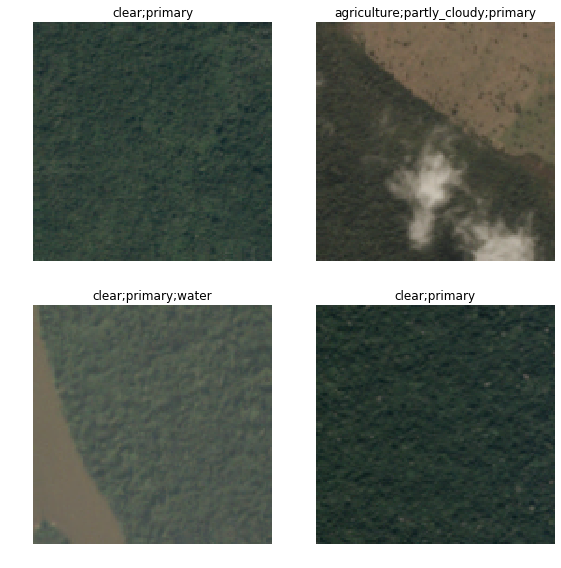

In [11]:
db.show_batch(2, figsize=(8,8))

In [10]:
f2 = partial(fbeta, thresh=0.2)
acc_02 = partial(accuracy_thresh, thresh=0.2)
learn = cnn_learner(db, models.resnet50, metrics=[acc_02, f2])

In [72]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


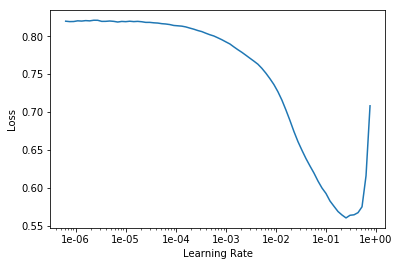

In [73]:
learn.recorder.plot()

In [75]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.126836,0.105307,0.948574,0.904297,01:19
1,0.108713,0.104432,0.940319,0.901754,00:48
2,0.097956,0.095656,0.956269,0.916883,00:47
3,0.092466,0.087214,0.957417,0.922260,00:48
4,0.087310,0.083953,0.955572,0.925655,00:48


In [76]:
learn.save('r50-128-stage1')

In [77]:
learn.unfreeze()
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


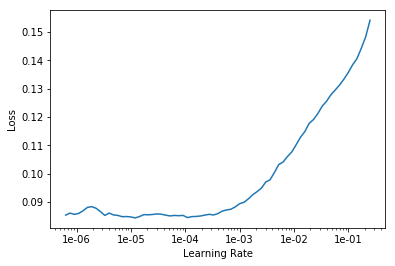

In [78]:
learn.recorder.plot()

In [80]:
learn.fit_one_cycle(4, slice(1e-5, 1e-2/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.089557,0.090763,0.951619,0.919387,01:02
1,0.090475,0.086405,0.952774,0.925101,01:02
2,0.087393,0.083172,0.954293,0.927029,01:02
3,0.082124,0.081945,0.957839,0.927245,01:02


In [81]:
learn.fit_one_cycle(3, slice(1e-5, 1e-2/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086250,0.087948,0.956160,0.919473,01:02
1,0.085301,0.084080,0.953857,0.924582,01:03
2,0.079720,0.081335,0.958202,0.927816,01:02


In [83]:
learn.save('r50-128-stage2')

## 256x256

In [11]:
img_size = 256
bs = 128

In [12]:
db = (data_src.transform(tfms, size=img_size)
      .databunch(bs=bs)
      .normalize(imagenet_stats))

In [13]:
learn = cnn_learner(db, models.resnet50, metrics=[acc_02, f2])

In [168]:
learn.load('r50-128-stage2');

In [90]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


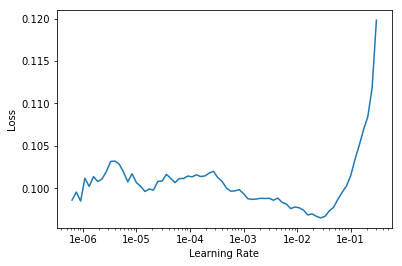

In [91]:
learn.recorder.plot()

In [94]:
learn.fit_one_cycle(5, 1e-2/2)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.084118,0.084182,0.955245,0.924647,02:43
1,0.084837,0.084132,0.956327,0.925315,02:41
2,0.082966,0.081030,0.957316,0.929335,02:41
3,0.079552,0.080543,0.958558,0.928811,02:41
4,0.079199,0.080436,0.958326,0.929086,02:41


In [95]:
learn.save('r50-256-stage1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


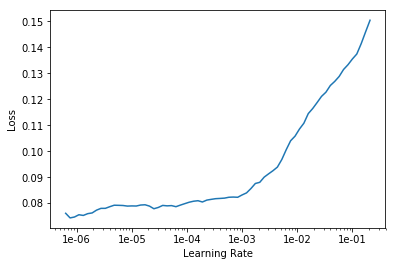

In [15]:
learn.load('r50-256-stage1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

### Choosing the learning rate
Find the learning rate at which the loss started to shoot up - that's about 1e-3. Use 10 times less than that for training the early layers.
For the final layer, use the same learning rate that was used before unfreezing divided by a factor of 5 to 10.

In [16]:
learn.fit_one_cycle(5, slice(1e-5, 1e-2/2/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.082255,0.077823,0.960520,0.932467,03:31
1,0.084025,0.079856,0.958696,0.930131,03:29
2,0.080219,0.077637,0.960419,0.932581,03:29
3,0.078719,0.075365,0.960266,0.934794,03:29
4,0.076604,0.075138,0.959924,0.934227,03:29


In [17]:
learn.save('r50-256-stage2')

# Submit to Kaggle
## Find threshold for fbeta (Single one for all classes)
We determine it by iterating over different values (0 to 1) and finding one for which the f2 metric performance on the validation set
is best and using that for thresholding on the test set.

In [14]:
learn.load('r50-256-stage2');

In [40]:
preds, targs = learn.get_preds(DatasetType.Valid)

In [39]:
preds_raw = torch.log(preds/(1-preds)) # inverse_of_sigmoid
learn.metrics[0](preds_raw, targs), learn.metrics[1] (preds_raw, targs)

(tensor(0.9612), tensor(0.9382))

In [56]:
thresholds = np.linspace(0.0, 1.0, 100)
f2s = np.zeros_like(thresholds)
for i, t in enumerate(thresholds):
    f2s[i] = fbeta(preds_raw, targs, thresh=t)

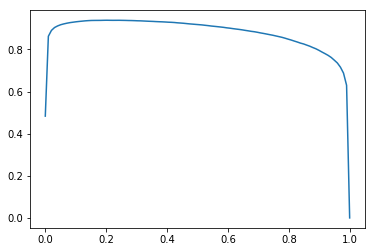

In [57]:
plt.plot(thresholds, f2s)

In [58]:
f2s.max(), f2s.argmax(), thresholds[f2s.argmax()]

(0.938323974609375, 20, 0.20202020202020204)

The best threshold is 0.2.

## Create submission csv and submit it

In [188]:
thresh = 0.2

In [183]:
test_preds, _ = learn.get_preds(DatasetType.Test)

In [184]:
labelled_preds = [' '.join([learn.data.classes[i] for i, p in enumerate(pred) if p > thresh]) for pred in test_preds]
labelled_preds[:3]

['clear cloudy primary', 'cloudy', 'clear primary']

In [185]:
test_fnames = [f.stem for f in learn.data.test_dl.items]

In [186]:
df = pd.DataFrame({'image_name': test_fnames, 'tags': labelled_preds}, columns=['image_name', 'tags']); df.head()

,image_name,tags
0,test_24954,clear cloudy primary
1,test_19317,cloudy
2,test_13909,clear primary
3,test_18575,clear habitation primary road water
4,file_18404,agriculture clear primary road


In [187]:
df.to_csv('planet_submission.csv', index=False)

In [ ]:
!kaggle competitions submit planet-understanding-the-amazon-from-space -f planet_submission.csv -m "First submission."